In [11]:
import pandas as pd
import csv
import pickle as pkl
import numpy as np
from fasttext import FastText
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime


In [12]:
model = FastText.load_model('cc.en.300.bin')

In [13]:
class Embeddings:
    def __init__(self, model) -> None:
        self.model = model
    def get_embeddings(self, words):
        return np.array([self.model.get_word_vector(i) for i in words])
    

In [14]:
tags = pkl.load(open('./tags.pkl', 'rb'))

In [15]:
embedding_class = Embeddings(model)
ems = embedding_class.get_embeddings(tags[:100])

In [16]:
anew_dataset = pd.read_csv('./warriner_raw.csv')

In [17]:
anew_dict= dict()
words = anew_dataset['term']
valence_ratings = anew_dataset['pleasure']
arousal_ratings = anew_dataset['arousal']
word_embeddings = embedding_class.get_embeddings(words)
word_embedding_dict = dict(zip(words, word_embeddings))
for i in range(len(words)):
    anew_dict[words[i]] = [valence_ratings[i], arousal_ratings[i]]

In [18]:
X = word_embeddings
Y = np.array([anew_dict[i] for i in words])

In [19]:
Y

array([[6.26, 2.41],
       [5.3 , 2.65],
       [2.84, 3.73],
       ...,
       [7.  , 5.63],
       [5.86, 5.68],
       [6.3 , 4.18]])

In [20]:
words

0           aardvark
1            abalone
2            abandon
3        abandonment
4              abbey
            ...     
13909           zone
13910         zoning
13911            zoo
13912           zoom
13913       zucchini
Name: term, Length: 13914, dtype: object

In [21]:
X

array([[-0.03986298,  0.00379052, -0.0127756 , ..., -0.01078152,
        -0.02300994,  0.0079215 ],
       [ 0.02610103,  0.01788571,  0.00896458, ...,  0.0547346 ,
         0.02627475,  0.02617722],
       [-0.01662364, -0.06317363,  0.10360997, ..., -0.00658366,
        -0.00859841, -0.0122865 ],
       ...,
       [ 0.01154633,  0.02386309,  0.02965424, ...,  0.02644203,
         0.09439246,  0.01073311],
       [ 0.01526884, -0.06252627,  0.06748683, ..., -0.06219679,
        -0.09277178, -0.06651503],
       [ 0.04610313,  0.01816115,  0.03932561, ..., -0.00771078,
        -0.03635433,  0.0058565 ]], dtype=float32)

In [22]:

Y = Y/9
# SCaling the data -- large loss issues. 

In [23]:
Y

array([[0.69555556, 0.26777778],
       [0.58888889, 0.29444444],
       [0.31555556, 0.41444444],
       ...,
       [0.77777778, 0.62555556],
       [0.65111111, 0.63111111],
       [0.7       , 0.46444444]])

In [24]:
X

array([[-0.03986298,  0.00379052, -0.0127756 , ..., -0.01078152,
        -0.02300994,  0.0079215 ],
       [ 0.02610103,  0.01788571,  0.00896458, ...,  0.0547346 ,
         0.02627475,  0.02617722],
       [-0.01662364, -0.06317363,  0.10360997, ..., -0.00658366,
        -0.00859841, -0.0122865 ],
       ...,
       [ 0.01154633,  0.02386309,  0.02965424, ...,  0.02644203,
         0.09439246,  0.01073311],
       [ 0.01526884, -0.06252627,  0.06748683, ..., -0.06219679,
        -0.09277178, -0.06651503],
       [ 0.04610313,  0.01816115,  0.03932561, ..., -0.00771078,
        -0.03635433,  0.0058565 ]], dtype=float32)

In [25]:
pkl.dump(X, open('X.pkl', 'wb'))
pkl.dump(Y, open('Y.pkl', 'wb'))


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)
test_dataset = TensorDataset(X_test, y_test)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [28]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [29]:
device

'cpu'

In [30]:
class NetworkModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(300, 150)
        self.linear_stack = nn.Sequential(
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(150, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
        )
        self.output = nn.Linear(5, 2)

    def forward(self, x):
        x = self.input(x)
        x = self.linear_stack(x)
        x = self.output(x)
        return x



In [31]:
train = True
if(train == True):
    best_loss = 10000
    model_train = NetworkModel().to(device)
    best_model = model_train.state_dict()
    epochs = 60
    learning_rate = 16e-5
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model_train.parameters(), lr=learning_rate)
    test_loss = []
    train_loss = []
    for i in range(epochs):
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            Y_pred = model_train(X.float())
            loss = loss_fn(Y_pred, Y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        # Test Loss
        with torch.no_grad():
            for X, Y in test_loader:
                X, Y = X.to(device), Y.to(device)
                Y_pred = model_train(X.float())
                test_loss_fn = loss_fn(Y_pred, Y.float())
            print(f'Epoch {i}, Training Loss: {loss.item()}, Test Loss: {test_loss_fn.item()}')
            test_loss.append(test_loss_fn.item())
            if(test_loss_fn.item() < best_loss):
                best_loss = test_loss_fn.item()
                best_model = model_train.state_dict()

Epoch 0, Training Loss: 0.06684678047895432, Test Loss: 0.050760380923748016
Epoch 1, Training Loss: 0.04263759031891823, Test Loss: 0.03243699297308922
Epoch 2, Training Loss: 0.04355083405971527, Test Loss: 0.0219583697617054
Epoch 3, Training Loss: 0.028956186026334763, Test Loss: 0.01788204535841942
Epoch 4, Training Loss: 0.018020866438746452, Test Loss: 0.01957821100950241
Epoch 5, Training Loss: 0.01165289618074894, Test Loss: 0.011968214064836502
Epoch 6, Training Loss: 0.0043008956126868725, Test Loss: 0.01163704227656126
Epoch 7, Training Loss: 0.014549708925187588, Test Loss: 0.010042461566627026
Epoch 8, Training Loss: 0.009714298881590366, Test Loss: 0.004884866066277027
Epoch 9, Training Loss: 0.007247136440128088, Test Loss: 0.00761767290532589
Epoch 10, Training Loss: 0.005845861509442329, Test Loss: 0.007925717160105705
Epoch 11, Training Loss: 0.005826178006827831, Test Loss: 0.00807410292327404
Epoch 12, Training Loss: 0.007616942748427391, Test Loss: 0.0091720549389

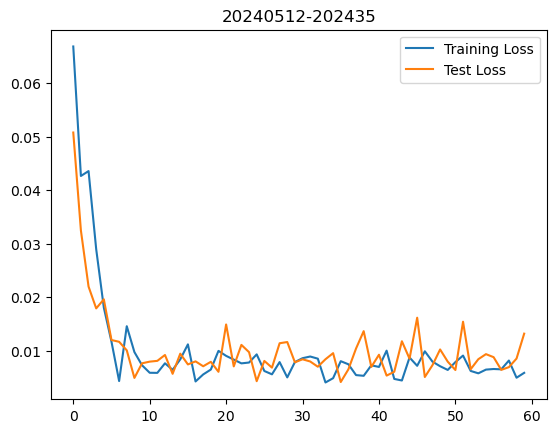

In [32]:
plt.plot(train_loss[:], label='Training Loss')
plt.plot(test_loss[:], label='Test Loss')
plt.legend()
datestring = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plt.title(datestring)
plt.savefig(f'./train_logs/{datestring}.png')

In [33]:
array = []
for i in range(len(X_test)):
    X_out = model_train(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    array.append((sum((X_out - Y_out)**2)))
    # array.append(loss_fn(X_out, Y_out).item())

In [34]:
array.sort()

In [35]:
torch.mean(array)

TypeError: mean(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
array

[tensor(7.9262e-07, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(7.9129e-06, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(9.6160e-06, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.3958e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.5100e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.7761e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(2.7996e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.1430e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.2514e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(3.7277e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(4.0171e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(5.3096e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(5.4564e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(6.4358e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(6.4402e-05, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(7.

In [ ]:
test_loss[-1]

0.006952543277293444

In [36]:
best_loss

0.0041168127208948135

In [37]:
new_model = NetworkModel()
new_model.load_state_dict(best_model)

<All keys matched successfully>

In [38]:
array = []
for i in range(len(X_test)):
    X_out = new_model(X_test[i].float())
    # print(X_out)
    Y_out= y_test[i]
    # print(Y_out)
    array.append((sum((X_out - Y_out)**2)).item())
    # array.append(loss_fn(X_out, Y_out).item())
print(sorted(array)[::-1])

[0.20046612083439563, 0.18230265347225605, 0.16290003632501426, 0.15127444118333783, 0.14773261097865975, 0.13832314989364072, 0.12533755131575616, 0.12278560870142934, 0.11918393400656563, 0.11901204270457105, 0.11750983957512642, 0.1142529720617568, 0.10664505614225023, 0.10631713113045319, 0.10447450239504284, 0.10052420478327359, 0.09899732188821747, 0.0985560273665261, 0.09700937702653742, 0.09632014177828949, 0.0948912426381513, 0.09428158183486657, 0.09368346492229337, 0.09340462645651454, 0.09221900501746641, 0.089615642349304, 0.08945062745740148, 0.08918755649278629, 0.08801293927734603, 0.08797380307190467, 0.08674019073173528, 0.08597606834623915, 0.0851456885468848, 0.08504816800045911, 0.08396749868331524, 0.08380619286645526, 0.08333772184534835, 0.08174679459584684, 0.07961691873838411, 0.07954165028393693, 0.07860631223824951, 0.07833092123469837, 0.0781473914468418, 0.07807984947639929, 0.07719480739581996, 0.07694520875478972, 0.07665020312438461, 0.07652369084824033

In [ ]:
array.sort()
array[::-1]

In [ ]:
np.median(array)

0.008284977062343048

In [39]:
torch.save(best_model, f'./model_freezes/{datestring}.pth')

In [40]:
datestring

'20240512-202435'